<a href="https://colab.research.google.com/github/saluisto/FINIFLUX/blob/main/gpinn_k2_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-6-45ace845cb15>:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = df['time'].dt.total_seconds()/(60*60*24)


Compiling model...
Building feed-forward neural network...
'build' took 0.146485 s

'compile' took 1.310883 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.66e-03, 2.54e-03, 4.42e+04]    [1.66e-03, 2.54e-03, 4.42e+04]    []  
1000      [8.15e-06, 7.00e-06, 3.64e+02]    [8.15e-06, 7.00e-06, 3.64e+02]    []  
2000      [7.52e-06, 7.89e-06, 3.10e+02]    [7.52e-06, 7.89e-06, 3.10e+02]    []  
3000      [1.42e-06, 1.97e-05, 3.09e+02]    [1.42e-06, 1.97e-05, 3.09e+02]    []  
4000      [1.85e-05, 1.91e-04, 3.09e+02]    [1.85e-05, 1.91e-04, 3.09e+02]    []  
5000      [7.55e-05, 4.23e-05, 3.00e+02]    [7.55e-05, 4.23e-05, 3.00e+02]    []  
6000      [2.46e-01, 6.70e-03, 2.77e+02]    [2.46e-01, 6.70e-03, 2.77e+02]    []  
7000      [1.03e-02, 2.32e-03, 1.17e+02]    [1.03e-02, 2.32e-03, 1.17e+02]    []  
8000      [2.22e-01, 1.30e-03, 1.01e+02]    [2.22e-01, 1.30e-03, 1.01e+02]    []  
9000      [1.54e-01, 5.93e-03, 9.

KeyboardInterrupt: 

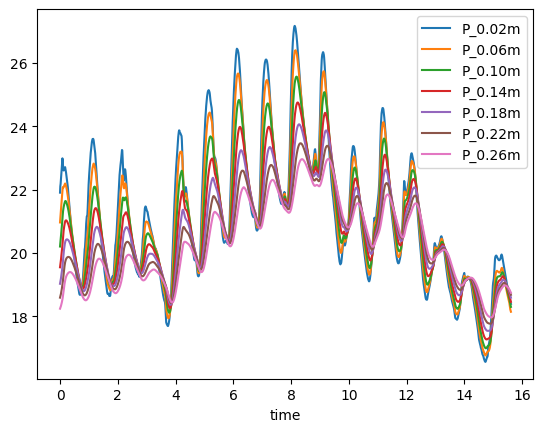

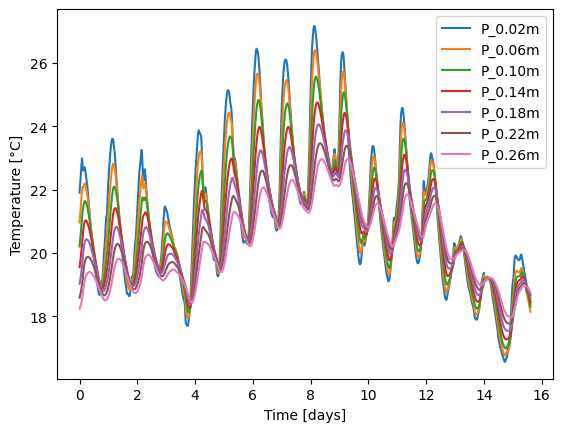

In [ ]:
"""
Created on Sun Feb  2 11:09:25 2025

@author: svenf
"""

!pip install deepxde
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import tensorflow as tf
from deepxde.callbacks import Callback
import os
import seaborn as sns
#%% This section reads the measured temperature in different depths to setup the boundary conditions and
# to solve for the advective flow velocity

def read_data(filename):
    df = pd.read_csv(filename)
    obs_data = df.dropna()
    obs_data=obs_data.drop(index=range(4))
    return obs_data

class DynamicLossWeights(Callback):
    def __init__(self, initial_weights , print_every=1000):
        """
        Initializes the callback with initial weights for the loss terms.

        Args:
            initial_weights (list or array): Initial weights for each loss term.
        """
        self.weights = np.array(initial_weights)
        self.model = None  # Placeholder for the model instance
        self.print_every = print_every

    def on_train_begin(self):
        """
        Ensures the model is properly initialized at the start of training.
        """
        if not hasattr(self, "model"):
            raise ValueError("The model must be set before training begins.")

    def on_epoch_end(self):
        """
        Updates the loss weights dynamically at the end of each training epoch.
        """
        if self.model is None:
            raise ValueError("Model has not been set for the DynamicLossWeights callback.")

        # Access the current training losses
        losses = np.array(self.model.train_state.loss_train)
        if np.any(losses == 0):
            print("Warning: Zero loss encountered, skipping weight update.")
            return

        # Compute new dynamic weights
        norm_losses = losses / np.sum(losses)  # Normalize losses
        self.weights = 1 / (norm_losses + 1e-6)  # Inverse of normalized loss
        self.weights /= np.sum(self.weights)  # Normalize weights to sum to 1

        # Debugging output
        epoch = self.model.train_state.epoch
        if epoch % self.print_every == 0:

            print(f"Epoch {self.model.train_state.epoch}: Updated weights: {self.weights}")
            print('......................................................................')
        # Apply the updated weights to the model
        self.model.loss_weights = self.weights.tolist()

class PrintLossLR(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.epoch_counter = 0  # Track epochs manually

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_counter += 1
        if self.epoch_counter % 1000 == 0:
            lr = self.model.optimizer._decayed_lr(tf.float32).numpy()
            loss = logs.get('loss')
            print(f"Epoch {self.epoch_counter}: Loss = {loss:.6f}, Learning Rate = {lr:.6e}")


import deepxde as dde
import numpy as np

class StopWhenLossBelowThreshold(dde.callbacks.Callback):
    def __init__(self, threshold):
        self.threshold = threshold
        self.model = None  # Will be assigned later

    def on_train_begin(self):
        """Assign model reference when training begins."""
        self.model = self.model  # Ensures self.model is properly assigned

    def on_epoch_end(self):
        """Check loss at end of epoch and stop training if below threshold."""
        if self.model is not None:
            loss_array = np.array(self.model.train_state.loss_train)  # Convert loss to numpy array
            total_loss = np.sum(loss_array)  # Option 1: Use total loss

            # Alternative: Use mean loss instead
            # total_loss = np.mean(loss_array)

            if total_loss < self.threshold:
                print(f"Stopping training: Total loss {total_loss:.6f} is below threshold {self.threshold}")
                self.model.stop_training = True  # Stop training






df=read_data(filename='K2_cal.csv')
gPINN=0 #flag for PINN or gPINN


df['time'] = pd.to_datetime(df['datetime'], format="%d/%m/%Y %H:%M")
#df = df.drop('depth1', axis=1)
first_time = df['time'].min()
df['time'] = df['time'] - first_time

df=df.iloc[:1500]

# convert from days into seconds
df['time'] = df['time'].dt.total_seconds()/(60*60*24)
tmaxx=np.float32(df['time'].max())
tmax = dde.Variable(tmaxx)

time = df['time'].values.reshape(-1,1)

df.set_index('time', inplace=True)

# observation depths
observe_x = np.array([0,0.04,0.08,0.12,0.16,0.2,0.24]).reshape(-1,1)
observe_T = df[['P_0.02m','P_0.06m','P_0.10m','P_0.14m','P_0.18m','P_0.22m','P_0.26m']].values

LL=np.float32(observe_x[len(observe_x)-1])
L = dde.Variable(LL)


df.plot()
ax=df.plot()
ax.set_xlabel("Time [days]")
ax.set_ylabel("Temperature [°C]")
#%%
# In this section the part of the objective function is beeing defined that is associated withe the pdf (heat transport equation)

def pde(x, y):

    phi = 0.33 # porosity, unitless
    #roh_water=1028
    #roh_sed=2650
    #c_water=4068
    #C_sed= 792.45
    #ke=1.85*60*60*24 #ke is converted from J/(s m K) to J/(day m K)

    #Cw = c_water*roh_water
    Csed =  2.11e6



    ke=1.85*60*60*24
    Cw=4.11e6
    #Cs=2.12e6
    Cs = phi*Cw + (1-phi)*Csed

    D=ke/(Cs)

    a=Cw/(Cs)


    #Output of the NN is the temperature field T and q fluxes in time
    T, q = y[:, 0:1], y[:, 1:2]

    #derivatives that are needed for the heat transport equation

    dy_t = dde.grad.jacobian(y, x, i=0, j=1)  #i=0 means component of y --> i=0 Temperature i=1 q; j=0 is z and j=1 time
    dy_xx = dde.grad.hessian(y, x, component=0, i=0, j=0) #compoent = 0 is Temperature component = 1 is q
                                                          #x i,j = 0 is depth z i,j = 1 is time t meant is xi,xj
    dq_dx=dde.grad.jacobian(y, x, i=1, j=0)
    dy_dx = dde.grad.jacobian(y, x, i=0, j=0)

    if gPINN == 1:
        dy_tx = dde.grad.hessian(y, x, component=0, i=1, j=0)
        dy_tt = dde.grad.hessian(y, x, component=0, i=1, j=1)

        dy_xxx =dde.grad.jacobian(dy_xx, x, i=0, j=0)
        dy_xxt =dde.grad.jacobian(dy_xx, x, i=0, j=1)


        dq_dt=dde.grad.jacobian(y, x, i=1, j=1)
        dq_xt = dde.grad.hessian(y, x, component=1, i=0, j=1)
        dq_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)

        dy_xt=dde.grad.hessian(y, x, component=0, i=0, j=1)

        return [dy_t-D*dy_xx+a*q*dy_dx+a*T*dq_dx,
                dy_tx-D*dy_xxx+a*dq_dx*dy_dx+a*q*dy_xx+a*dy_dx*dq_dx+a*T*dq_xx,
                dy_tt-D*dy_xxt+a*dq_dt*dy_dx+a*q*dy_xt+a*dy_t*dq_dx+a*T*dq_xt,
                dq_dx]
    else:
        return [dy_t-D*dy_xx+a*q*dy_dx+a*T*dq_dx,
                dq_dx]



#%%
#Define where observations are located and define IC and BC



xx, tt = np.meshgrid(observe_x,time)
X = np.vstack((np.ravel(xx), np.ravel(tt))).T #x,t


train_set=1
set_cout=int(train_set*len(tt))
X_train = np.vstack((np.ravel(xx[:set_cout]), np.ravel(tt[:set_cout]))).T #x,t
observe_T=np.ravel(observe_T[:set_cout]).reshape(-1,1)
observe_u = dde.icbc.PointSetBC(X_train,observe_T,component=0)

#%% Define the model gometry in space and time

max_time=tmaxx
geom = dde.geometry.Interval(0,LL)
timedomain = dde.geometry.TimeDomain(0, max_time)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

#%
data = dde.data.TimePDE(
    geomtime,
    pde,
    [observe_u],
    num_domain=0,
    anchors=X,
)

# Here different neural network structures are beeing tested PFNN are
# DeepONET networks /(https://www.nature.com/articles/s42256-021-00302-5)

net = dde.nn.PFNN([2, [40, 40], [40, 40], [40, 40], [40, 40], 2], "tanh", "Glorot uniform")
#net = dde.nn.PFNN([2, [40, 30], [40, 30], [40, 30], 2], "tanh", "Glorot uniform")
#net = dde.nn.PFNN([2, [100, 100], [100, 100], [100, 100], 2], "tanh", "Glorot uniform")
#net = dde.nn.PFNN([2, [10, 50], [10, 50], [10, 50], 2], "tanh", "Glorot uniform")
#net = dde.nn.FNN([2, [200, 200], [200, 200], 2], "tanh", "Glorot uniform")
#net = dde.nn.PFNN([2, [200, 200], [200, 200], 2], "tanh", "Glorot uniform")
#net = dde.nn.PFNN([2, [50, 50], [50, 50], 2], "tanh", "Glorot uniform")


model = dde.Model(data, net)

#dde.config.set_default_float("float32")

#model.compile("adam", lr=0.01,loss_weights=[1, 1, 1, 100, 100])
#model.restore("backup\model.ckpt")

# Define dynamic weights
if gPINN==1:
    initial_weights = [1, 1, 1, 1, 1]
else:
    initial_weights = [1, 1, 1]

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.75,
                                                 patience=10, min_lr=1e-6, verbose=1)





# Custom loss weights
#weights = dde.callbacks.LossWeightsScheduler(loss_weights_callback)

# Define your loss threshold
loss_threshold = 6e-3  # Adjust this as needed
iterations=1000

# Create the callback
stop_callback = StopWhenLossBelowThreshold(loss_threshold)
dynamic_loss = DynamicLossWeights(initial_weights,print_every=1000)
#runs=7


model.compile("adam", lr=0.0005,loss_weights=[1, 1, 100])
losshistory, train_state = model.train(iterations=iterations,callbacks=[stop_callback])

model.compile("adam", lr=0.0001,loss_weights=dynamic_loss.weights)
losshistory, train_state = model.train(iterations=1000000,callbacks=[dynamic_loss, stop_callback])

#losshistory, train_state = model.train(iterations=iterations,callbacks=[callback, PrintLossLR()])
#losshistory, train_state = model.train(iterations=iterations,callbacks=[reduce_lr])


# Parameters for learning rate reduction
reduce_lr_factor = 0.5  # Factor by which to reduce the learning rate
reduce_lr_patience = 10  # Number of epochs to wait before reducing LR
min_learning_rate = 1e-6  # Minimum allowed learning rate
best_loss = np.inf  # Track the best loss
wait = 0  # Counter for epochs without improvement





#iterations=100000
#model.compile("adam", lr=0.001,loss_weights=[1, 1, 1, 100, 100])
#losshistory, train_state = model.train(iterations=iterations)

#iterations=200000
#model.compile("adam", lr=0.0001,loss_weights=[1, 1, 1, 100, 100])
#losshistory, train_state = model.train(iterations=iterations)

#model.compile("L-BFGS-B",loss_weights=[1, 1, 1, 100, 100])
#losshistory, train_state = model.train()



# I am using a two step learning procedure. Here is the second step using L-BFGS-B
#model.compile("L-BFGS-B",loss_weights=[1, 1])
#losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

# Save the model's weights
#model.save("backup\model.ckpt")



Y = model.predict(X)
#%%
#Plotting the different predictions vs observations

for i in range(len(observe_x)):
    dp = ['P_0.02m','P_0.06m','P_0.10m','P_0.14m','P_0.18m','P_0.22m','P_0.26m']
    columns = ['X[m]', 'Time[days]', 'T[C]', 'q[m/day]']
    sim=np.concatenate((X,Y),axis=1)
    result = pd.DataFrame(sim, columns=columns)

    rslt_d1 = result[result['X[m]'] == float(observe_x[i])]
    rslt_d1= rslt_d1.drop('X[m]',axis=1)
    #rslt_d1['Time[days]'] = rslt_d1['Time[days]']* tmaxx

    rslt_d1.plot(x='Time[days]', y='T[C]', kind='scatter', title='Temp_simulated')
    df[dp[i]].plot(kind='line', title=dp[i],color='r')

    rslt_d1.plot(x='Time[days]', y='q[m/day]', kind='line', title='Temp_simulated')

    if i == 4:
        save_dir = "E:/neural_network/temp_AI/GITHUB/figs_2/"
        d4=rslt_d1
        d4_ref=df[dp[i]]

        state=train_state.best_loss_test

        title='Iterations = ' + str(iterations) + " || loss = "+f"{state:.2e}"
        file=str(iterations)+'.tif'

        file_path = os.path.join(save_dir, file)
        rslt_d1['PINN']=rslt_d1['T[C]']

        # rslt_d1.plot(x='Time[days]', y='PINN', kind='line', title=title, legend=False)
        # df[dp[i]].plot(kind='line', title=dp[i],color='r')
        # plt.xlabel('Time[days]')  # Label for x-axis
        # plt.ylabel('Temperature [°C]')
        # plt.ylim(0, 27)

        #plt.title(title)



        fig, axs = plt.subplots(2, 1)

        #rslt_d1.plot(ax=axs[0, 0],x='Time[days]', y='T', kind='line', title=title, legend=False)
        sns.lineplot(x='Time[days]', y='T[C]', data=rslt_d1, ax=axs[0], color='blue')
        sns.lineplot(x='time', y=df[dp[i]], data=df, ax=axs[0], color='red')
        axs[0].set_ylim(0, 28)
        axs[0].set_title(title)
        axs[0].set_xlabel('')
        axs[0].set_ylabel('Temperature [°C]')
        sns.lineplot(x='Time[days]', y='q[m/day]', data=rslt_d1, ax=axs[1], color='black')
        axs[1].set_ylim(-1.1, 1.1)
        plt.tight_layout()
        plt.show()

        #plt.savefig(file_path, format='tiff', dpi=300)  # High-resolution (300 DPI)
        plt.close()